In [1]:
import xarray as xr
import cftime
import numpy as np
import glob
import warnings
warnings.filterwarnings("ignore")
from eofs.xarray import Eof
import matplotlib.pyplot as plt
from matplotlib import colors as c
from matplotlib.gridspec import GridSpec

In [2]:
#===========Plotters
import cartopy as cart
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nc_time_axis
import cftime
import seaborn as sn

In [3]:
import sys
sys.path.append("..")

In [4]:
from scripts.eof_utilities import calculate_anomaly, eofcalc_pcnorm, proj_onto_eof, EucDistance

## Load Data 

In [5]:
#------------ US bounding box in lat/lon (degrees)
us_lat_bounds = (24.031414, 49.47644)
us_lon_bounds = (233.75, 293.75)
figure = "/glade/work/ksilwimba/SPMIP_Project/spmip_code/ncar_system/spmip-eof-analysis/figures"
#------------ Data directory
path = "/glade/work/ksilwimba/SPMIP_Project/spmip_data/SPMIP_Data"

# -- CLM5 Experiments: sum layers 0 to 8 --
data_CLM5_Exp1  = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp1_1980-2010.nc").mrlsl.sel(levsoi=slice(0, 8)).sum("levsoi")
data_CLM5_Exp2  = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp2_1980-2010.nc").mrlsl.sel(levsoi=slice(0, 8)).sum("levsoi")
data_CLM5_Exp3  = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp3_1980-2010.nc").mrlsl.sel(levsoi=slice(0, 8)).sum("levsoi")
data_CLM5_Exp4a = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp4a_1980-2010.nc").mrlsl.sel(levsoi=slice(0, 8)).sum("levsoi")
data_CLM5_Exp4b = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp4b_1980-2010.nc").mrlsl.sel(levsoi=slice(0, 8)).sum("levsoi")
data_CLM5_Exp4c = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp4c_1980-2010.nc").mrlsl.sel(levsoi=slice(0, 8)).sum("levsoi")
data_CLM5_Exp4d = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp4d_1980-2010.nc").mrlsl.sel(levsoi=slice(0, 8)).sum("levsoi")

# -- ERA5 Land data (daily) --
ERA5_land = (
    xr.open_dataset("/glade/work/ksilwimba/SPMIP_Project/spmip_data/ERA5_Data/ERA5_Land.nc")
      .resample(time="1D")
      .mean()
)
ERA5_land_mean = ERA5_land.__xarray_dataarray_variable__.mean(dim="time")
# -- Create a mask (1 where data is valid, NaN elsewhere) --
sm = xr.open_dataset(f"{path}/CLM5_SPMIP_Exp1_1980-2010.nc").mrlsl
mask = sm[0, 0, :, :] / sm[0, 0, :, :]  # 1 or NaN
lat = data_CLM5_Exp1.lat
lon = data_CLM5_Exp1.lon

## Computing the Ensemble Mean 

In [6]:
# Calculate the ensemble mean for the first three experiments
Ensemble_mean123 = (data_CLM5_Exp1 + data_CLM5_Exp2 + data_CLM5_Exp3) / 3

# Calculate the ensemble mean for the next four experiments
Ensemble_mean4 = (data_CLM5_Exp4a + data_CLM5_Exp4b + data_CLM5_Exp4c + data_CLM5_Exp4d) / 4
Ens_mean123 = (Ensemble_mean123 / 1000) * 1000
Ens_mean4 = (Ensemble_mean4 / 1000) * 1000

In [7]:
distance = EucDistance(data_CLM5_Exp1[:10957].mean(dim="time"), Ens_mean123[:10957].mean(dim="time"))
mask_arr = distance/distance 

### Computing the Seasons

In [8]:
# ======= Computing the Seasons =======

# Calculate the seasonal mean for each experiment and apply the mask
data_CLM5_Exp1_seas = data_CLM5_Exp1.groupby("time.season").mean("time") * mask
data_CLM5_Exp2_seas = data_CLM5_Exp2.groupby("time.season").mean("time") * mask
data_CLM5_Exp3_seas = data_CLM5_Exp3.groupby("time.season").mean("time") * mask
data_CLM5_Exp4a_seas = data_CLM5_Exp4a.groupby("time.season").mean("time") * mask
data_CLM5_Exp4b_seas = data_CLM5_Exp4b.groupby("time.season").mean("time") * mask
data_CLM5_Exp4c_seas = data_CLM5_Exp4c.groupby("time.season").mean("time") * mask
data_CLM5_Exp4d_seas = data_CLM5_Exp4d.groupby("time.season").mean("time") * mask

# Calculate the seasonal mean for ERA5 data and extract the variable of interest
data_ERA5_seas = ERA5_land.groupby("time.season").mean("time") * mask
data_ERA5_seas = data_ERA5_seas.__xarray_dataarray_variable__

# ======= Computing Temporal Means =======

# Compute time-averaged data for experiments across latitude and longitude
data_exp1_time = data_CLM5_Exp1.mean(dim=("lat", "lon"))
data_exp2_time = data_CLM5_Exp2.mean(dim=("lat", "lon"))
data_exp3_time = data_CLM5_Exp3.mean(dim=("lat", "lon"))

### Computing the Anamolies 

In [9]:
annom_data_CLM5_Exp1 = data_CLM5_Exp1.map_blocks(calculate_anomaly, template=data_CLM5_Exp1).compute()
annom_data_CLM5_Exp2 = data_CLM5_Exp2.map_blocks(calculate_anomaly, template=data_CLM5_Exp2).compute()
annom_data_CLM5_Exp3 = data_CLM5_Exp3.map_blocks(calculate_anomaly, template=data_CLM5_Exp3).compute()
annom_data_CLM5_Exp4a = data_CLM5_Exp4a.map_blocks(calculate_anomaly, template=data_CLM5_Exp4a).compute()
annom_data_CLM5_Exp4b = data_CLM5_Exp4b.map_blocks(calculate_anomaly, template=data_CLM5_Exp4b).compute()
annom_data_CLM5_Exp4c = data_CLM5_Exp4c.map_blocks(calculate_anomaly, template=data_CLM5_Exp4c).compute()
annom_data_CLM5_Exp4d = data_CLM5_Exp4d.map_blocks(calculate_anomaly, template=data_CLM5_Exp4d).compute()
annom_era5_land = ERA5_land.map_blocks(calculate_anomaly, template=ERA5_land).compute()

annom_Ensemble_mean123 = Ensemble_mean123.map_blocks(calculate_anomaly, template=Ensemble_mean123).compute()
annom_Ensemble_mean4 = Ensemble_mean4.map_blocks(calculate_anomaly, template= Ensemble_mean4).compute()

## Computing the Temporal Means 

In [10]:
exp1_annom = annom_data_CLM5_Exp1.mean(dim=("lat","lon"))
exp2_annom = annom_data_CLM5_Exp2.mean(dim=("lat","lon"))
exp3_annom = annom_data_CLM5_Exp3.mean(dim=("lat","lon"))  
exp4a_annom = annom_data_CLM5_Exp4a.mean(dim=("lat","lon")) 
exp4b_annom = annom_data_CLM5_Exp4b.mean(dim=("lat","lon")) 
exp4c_annom = annom_data_CLM5_Exp4c.mean(dim=("lat","lon")) 
exp4d_annom = annom_data_CLM5_Exp4d.mean(dim=("lat","lon"))

Ensemble_mean123_annom = annom_Ensemble_mean123.mean(dim=("lat","lon"))
Ensemble_mean4_annom = annom_Ensemble_mean4.mean(dim=("lat","lon"))


era5_land_annom = annom_era5_land.mean(dim=("lat","lon")) 
era5_land_annom = era5_land_annom.__xarray_dataarray_variable__

# Temporal Plot 

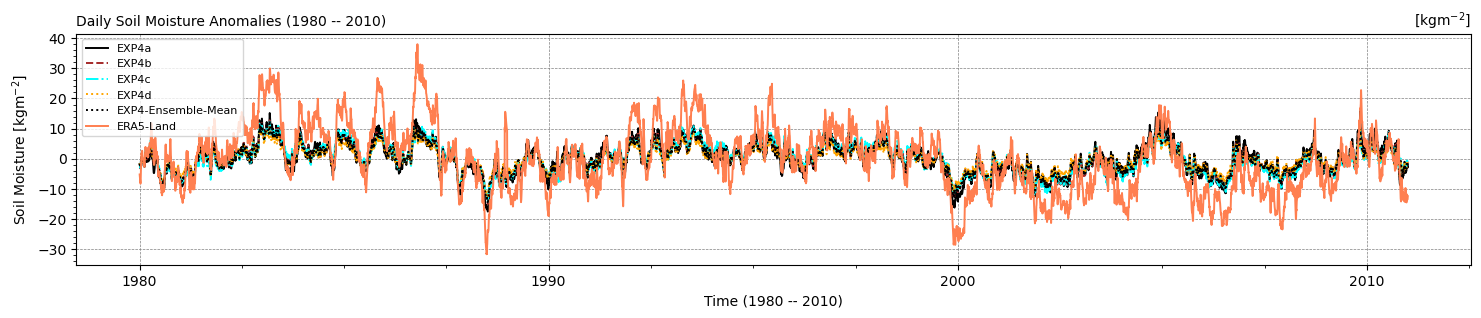

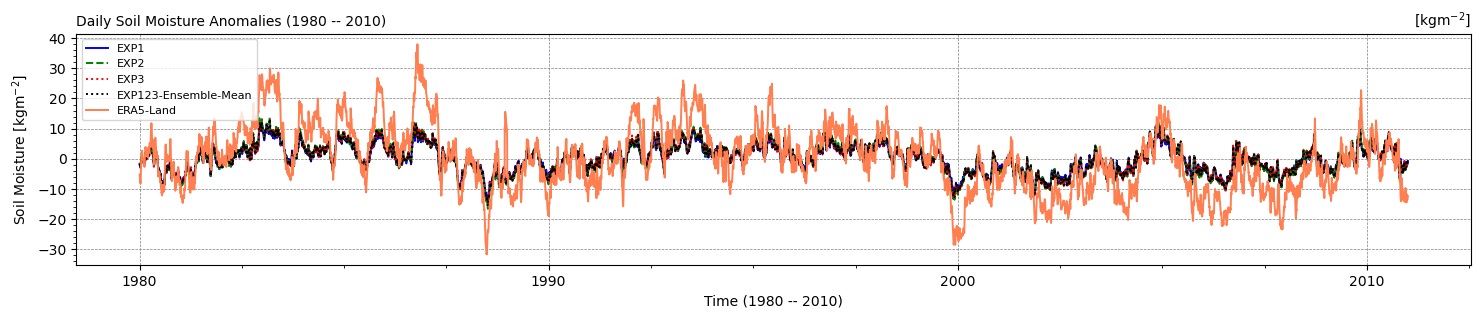

In [11]:
def annomaly_():
    plt.figure(figsize=(18,3))
    plt.title("Daily Soil Moisture Anomalies (1980 -- 2010)", fontsize=10, fontweight='regular', loc="left")
    plt.title("[kgm$^{-2}$]", fontsize=10, fontweight='regular', loc="right")
    plt.plot(annom_data_CLM5_Exp1.time, exp1_annom, 'b-' , linewidth=1.4)
    plt.plot(annom_data_CLM5_Exp1.time, exp2_annom, 'g--' , linewidth=1.4)
    plt.plot(annom_data_CLM5_Exp1.time, exp3_annom, 'r:' , linewidth=1.4)
    plt.plot(annom_data_CLM5_Exp1.time, Ensemble_mean123_annom, ':', c="black" , linewidth=1.4)
    plt.plot(annom_data_CLM5_Exp1.time, era5_land_annom[:11315].drop("dayofyear"), c='coral', linewidth=1.4)
    plt.legend(['EXP1','EXP2', "EXP3","EXP123-Ensemble-Mean",'ERA5-Land'], fontsize=8, loc="upper left")
    plt.xlabel("Time (1980 -- 2010)", fontweight='regular', fontsize=10)
    plt.ylabel("Soil Moisture [kgm$^{-2}$]", fontweight='regular', fontsize=10)
    plt.minorticks_on()
    plt.grid(linestyle='--', linewidth=0.5, color='grey')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.savefig(figure+"/Exp123_Daily_Ann_SPMIP_Map.pdf", dpi = 1000, bbox_inches='tight')
    
    
def annomaly():
    plt.figure(figsize=(18,3))
    plt.title("Daily Soil Moisture Anomalies (1980 -- 2010)", fontsize=10, fontweight='regular', loc="left")
    plt.title("[kgm$^{-2}$]", fontsize=10, fontweight='regular', loc="right")
    plt.plot(annom_data_CLM5_Exp1.time, exp4a_annom, c='black', linewidth=1.4, label='EXP4a')
    plt.plot(annom_data_CLM5_Exp1.time, exp4b_annom, '--',c="brown", linewidth=1.4, label='EXP4b')  # Dashed line
    plt.plot(annom_data_CLM5_Exp1.time, exp4c_annom, '-.',c="cyan", linewidth=1.4, label='EXP4c')  # Dash-dot line
    plt.plot(annom_data_CLM5_Exp1.time, exp4d_annom, ':',c="orange", linewidth=1.4, label='EXP4d')  # Dotted line
    plt.plot(annom_data_CLM5_Exp1.time, Ensemble_mean4_annom, ':',c="black", linewidth=1.4, label='EXP4-Ensemble-Mean')  # Dotted line
    plt.plot(annom_data_CLM5_Exp1.time, era5_land_annom[:11315].drop("dayofyear"), c='coral', linewidth=1.4, label='ERA5-Land')
    plt.legend(['EXP4a','EXP4b', "EXP4c", "EXP4d","EXP4-Ensemble-Mean",'ERA5-Land'], fontsize=8)
    plt.xlabel("Time (1980 -- 2010)", fontweight='regular', fontsize=10)
    plt.ylabel("Soil Moisture [kgm$^{-2}$]", fontweight='regular', fontsize=10)
    plt.minorticks_on()
    plt.grid(linestyle='--', linewidth=0.5, color='grey')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.savefig(figure+"/Exp4_Daily_Ann_SPMIP_Map.pdf", dpi = 1000, bbox_inches='tight')

annomaly()  
    
annomaly_()  

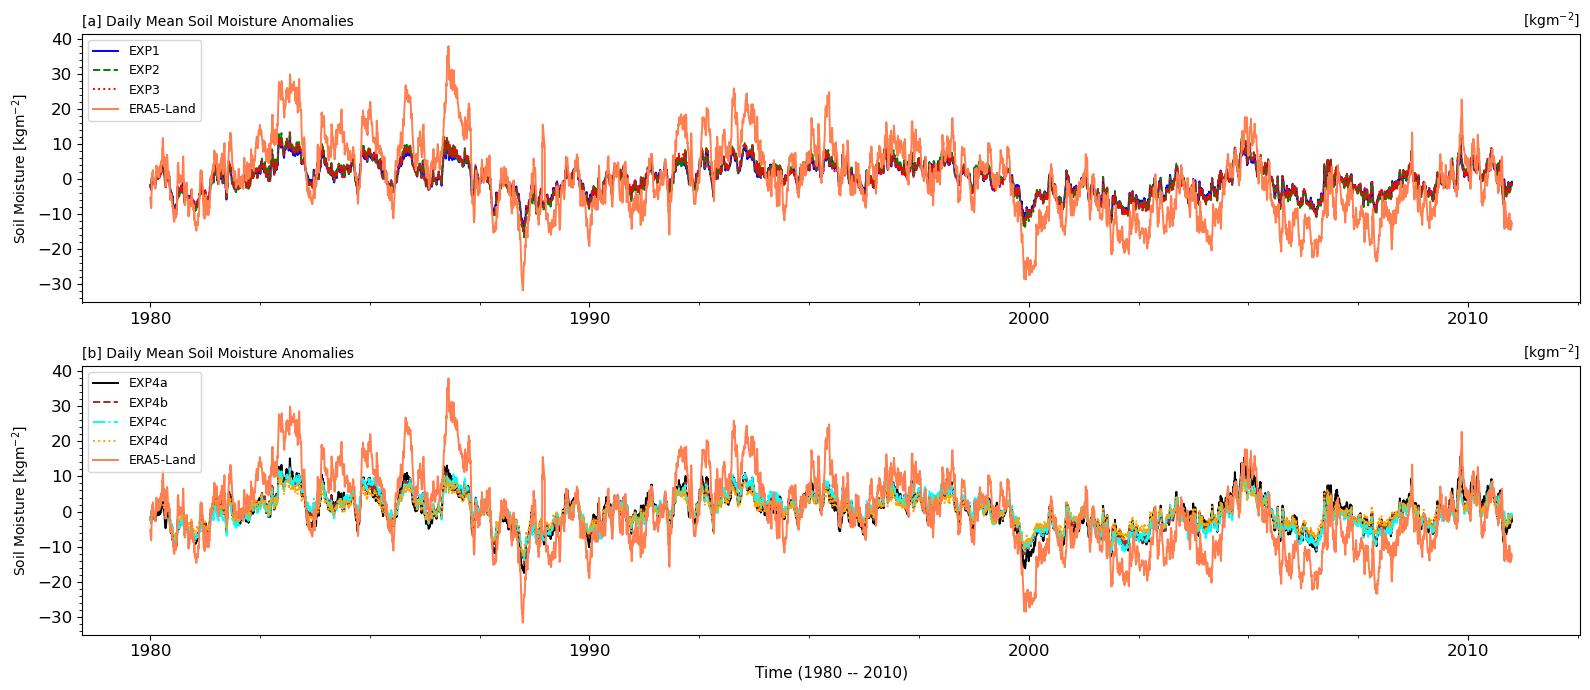

In [12]:
def plot_annomaly_subplot(ax, times, anomalies, labels, colors, linestyles, title, ylabel, xlabel=None):
    ax.set_title(title, fontsize=10, fontweight='regular', loc="left")
    ax.set_title("[kgm$^{-2}$]", fontsize=10, fontweight='regular', loc="right")
    for time, anomaly, label, color, linestyle in zip(times, anomalies, labels, colors, linestyles):
        ax.plot(time, anomaly, label=label, color=color, linestyle=linestyle, linewidth=1.4)
    ax.legend(fontsize=9, loc="upper left")
    if xlabel:  # Only set the xlabel if provided
        ax.set_xlabel(xlabel, fontweight='regular', fontsize=11)
    ax.set_ylabel(ylabel, fontweight='regular', fontsize=10)
    ax.minorticks_on()
    # ax.grid(linestyle='--', linewidth=0.5, color='grey')
    ax.tick_params(axis='both', which='major', labelsize=12)

fig, axs = plt.subplots(2, 1, figsize=(16, 7))  # Creates a figure and two vertical subplots

# Plot for the first set of anomalies without setting xlabel
plot_annomaly_subplot(
    axs[0],
    [annom_data_CLM5_Exp1.time] * 4 + [annom_data_CLM5_Exp1.time],
    [exp1_annom, exp2_annom, exp3_annom, era5_land_annom[:11315].drop("dayofyear")],
    ['EXP1', 'EXP2', 'EXP3', 'ERA5-Land'],
    ['b', 'g', 'r', 'coral'],
    ['-', '--', ':', '-'],
    "[a] Daily Mean Soil Moisture Anomalies",
    "Soil Moisture [kgm$^{-2}$]",
    xlabel=None  # Do not set the xlabel for the first subplot
)

# Plot for the second set of anomalies with xlabel
plot_annomaly_subplot(
    axs[1],
    [annom_data_CLM5_Exp1.time] * 5,
    [exp4a_annom, exp4b_annom, exp4c_annom, exp4d_annom, era5_land_annom[:11315].drop("dayofyear")],
    ['EXP4a', 'EXP4b', 'EXP4c', 'EXP4d', 'ERA5-Land'],
    ['black', 'brown', 'cyan', 'orange', 'coral'],
    ['-', '--', '-.', ':', '-'],
    "[b] Daily Mean Soil Moisture Anomalies",
    "Soil Moisture [kgm$^{-2}$]",
    xlabel="Time (1980 -- 2010)"  # Set the xlabel for the second subplot
)

plt.tight_layout()
plt.savefig(figure+"/Daily_Ann_SPMIP_Map.pdf", dpi=1000, bbox_inches='tight')


# Spatial Plot

In [13]:
def _make_contour_plot_(data_nc, ax, title, is_first_subplot=False, is_last_row=False):
    #=================== Choose the Multi-model ensemble (MME) and week1 (time index of 0)
    
    data, lons = add_cyclic_point(data_nc, coord=data_nc['lon'])
    lats = data_nc['lat']
    lons2d, lats2d = np.meshgrid(lons, lats)

    # Make a filled plot without contours using pcolormesh
    cs = ax.pcolormesh(lons2d, lats2d, data, transform=ccrs.PlateCarree(),
                         cmap='RdYlBu', shading='auto')

    states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_lines',scale='50m',facecolor='none')
    ax.add_feature(states, edgecolor='gray')
    # ax.set_title(title, fontweight='bold', fontsize=14, loc='right')
    ax.set_title(f"kgm$^{-2}$", loc='right', fontweight='regular', size=10)
        # Set longitude and latitude ticks
  
    ax.set_title(title, fontweight='regular', fontsize=10, loc='left')

      #=================== Define the yticks for latitude
    if is_last_row:
        ax.set_xticks(np.arange(-120, -60, 10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        
    if is_first_subplot:
        ax.set_yticks(np.arange(24, 50, 5), crs=ccrs.PlateCarree())
    # lat_formatter = cticker.LatitudeFormatter()
    # ax.yaxis.set_major_formatter(lat_formatter)
   
        lat_formatter = cticker.LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
    ax.minorticks_on()  # This would enable minor ticks on both axes
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle='-')
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle='-')
    ax.add_feature(cfeature.COASTLINE)
    return cs

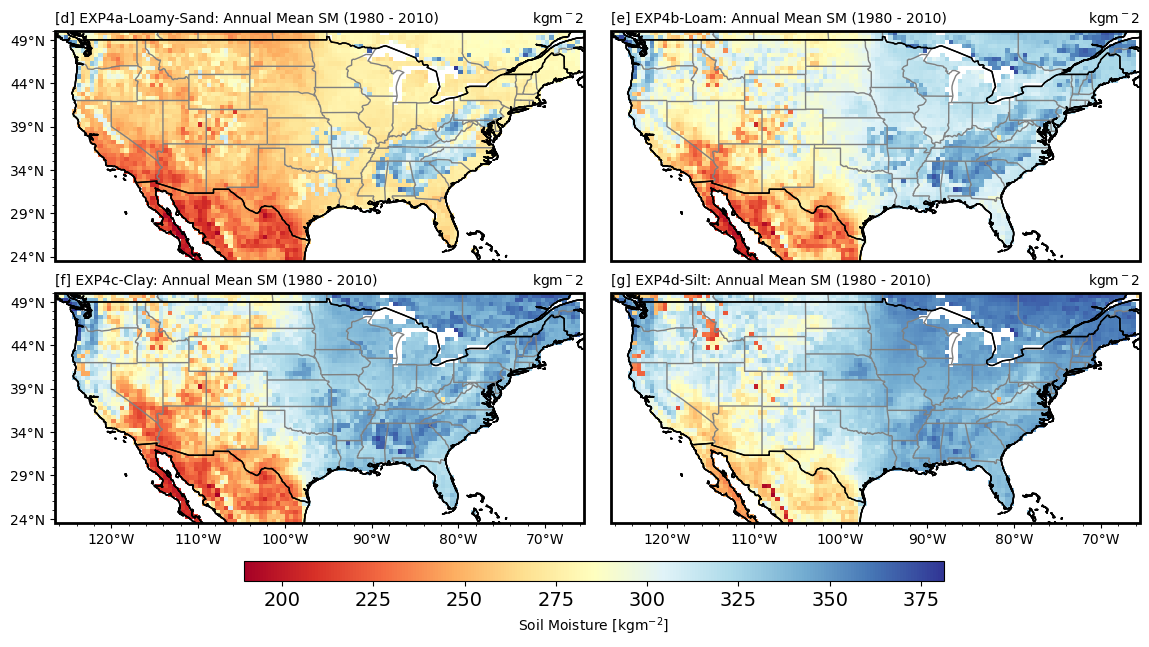

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[14, 8], \
                       subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.05, 'hspace': -0.12})
for axis in ax.flat:
    # Set the border color and width
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)
#============================================ Spatial Maps 

cs14a_ = _make_contour_plot_(data_CLM5_Exp4a.mean(axis=0)*mask ,  ax[0,0], '[d] EXP4a-Loamy-Sand: Annual Mean SM (1980 - 2010)', is_first_subplot=True)
cs14b_ = _make_contour_plot_(data_CLM5_Exp4b.mean(axis=0)*mask ,  ax[0,1], '[e] EXP4b-Loam: Annual Mean SM (1980 - 2010)')
cs14c_ = _make_contour_plot_(data_CLM5_Exp4c.mean(axis=0)*mask ,  ax[1,0], '[f] EXP4c-Clay: Annual Mean SM (1980 - 2010)', is_first_subplot=True, is_last_row=True)
cs14d_ = _make_contour_plot_(data_CLM5_Exp4d.mean(axis=0)*mask ,  ax[1,1], '[g] EXP4d-Silt: Annual Mean SM (1980 - 2010)', is_last_row=True)

# Create a single horizontal colorbar['DJF', 'JJA', 'MAM', 'SON']
fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.17, 0.5,  0.025])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(cs14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Soil Moisture [kgm$^{-2}$]', fontweight='regular', fontsize=10)
plt.savefig(figure+"/Exp4TotalSM_SPMIP_Map.pdf", dpi = 600, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[14, 8], \
                       subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.05, 'hspace': -0.12})
for axis in ax.flat:
    # Set the border color and width
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

cs1e = _make_contour_plot_(ERA5_land_mean*mask ,    ax[0,0], '[a] ERA5-Land: Annual Mean SM ', is_first_subplot=True)
cs11_ = _make_contour_plot_(data_CLM5_Exp1.mean(axis=0)*mask ,    ax[0,1], '[b] EXP1: Annual Mean SM')
cs12_ = _make_contour_plot_(data_CLM5_Exp2.mean(axis=0)*mask ,    ax[1,0], '[c] EXP2: Annual Mean SM', is_first_subplot=True, is_last_row=True)
cs13_ = _make_contour_plot_(data_CLM5_Exp3.mean(axis=0)*mask ,    ax[1,1], '[d] EXP3: Annual Mean SM', is_last_row=True)


fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.17, 0.5,  0.025])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(cs11_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Soil Moisture [kgm$^{-2}$]', fontweight='regular', fontsize=10)
plt.savefig(figure+"/exp123.pdf", dpi = 600, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=[20, 10], \
                       subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.02, 'hspace': -0.58})
for axis in ax.flat:
    # Set the border color and width
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)
#============================================ Spatial Maps 
cs1e = _make_contour_plot_(ERA5_land_mean*mask ,    ax[0,0], '[a] ERA5-Land: Annual Mean SM ', is_first_subplot=True)
cs11_ = _make_contour_plot_(data_CLM5_Exp1.mean(axis=0)*mask ,    ax[0,1], '[b] EXP1: Annual Mean SM')
cs12_ = _make_contour_plot_(data_CLM5_Exp2.mean(axis=0)*mask ,    ax[0,2], '[c] EXP2: Annual Mean SM')
cs13_ = _make_contour_plot_(data_CLM5_Exp3.mean(axis=0)*mask ,    ax[0,3], '[d] EXP3: Annual Mean SM')


cs14a_ = _make_contour_plot_(data_CLM5_Exp4a.mean(axis=0)*mask ,  ax[1,0], '[d] EXP4a-Loamy-Sand: Annual Mean SM', is_first_subplot=True, is_last_row=True)
cs14b_ = _make_contour_plot_(data_CLM5_Exp4b.mean(axis=0)*mask ,  ax[1,1], '[e] EXP4b-Loam: Annual Mean SM', is_last_row=True)
cs14c_ = _make_contour_plot_(data_CLM5_Exp4c.mean(axis=0)*mask ,  ax[1,2], '[f] EXP4c-Clay: Annual Mean SM', is_last_row=True)
cs14d_ = _make_contour_plot_(data_CLM5_Exp4d.mean(axis=0)*mask ,  ax[1,3], '[g] EXP4d-Silt: Annual Mean SM', is_last_row=True)

# Create a single horizontal colorbar['DJF', 'JJA', 'MAM', 'SON']
fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.3, 0.5,  0.025])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(cs14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Soil Moisture [kgm$^{-2}$]', fontweight='regular', fontsize=10)
plt.savefig(figure+"/b_ERA5_SM_Comp.pdf", dpi = 600, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=[15, 15], \
                       subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.02, 'hspace': 0.12})
for axis in ax.flat:
    # Set the border color and width
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)
#============================================ Spatial Maps 
cs1e = _make_contour_plot_(ERA5_land_mean*mask ,    ax[0,0], '[a] ERA5-Land: Annual Mean SM ', is_first_subplot=True)
cs11_ = _make_contour_plot_(data_CLM5_Exp1.mean(axis=0)*mask ,    ax[0,1], '[b] EXP1: Annual Mean SM')
cs12_ = _make_contour_plot_(data_CLM5_Exp2.mean(axis=0)*mask ,    ax[1,0], '[c] EXP2: Annual Mean SM', is_first_subplot=True)
cs13_ = _make_contour_plot_(data_CLM5_Exp3.mean(axis=0)*mask ,    ax[1,1], '[d] EXP3: Annual Mean SM')


cs14a_ = _make_contour_plot_(data_CLM5_Exp4a.mean(axis=0)*mask ,  ax[2,0], '[d] EXP4a-Loamy-Sand: Annual Mean SM', is_first_subplot=True)
cs14b_ = _make_contour_plot_(data_CLM5_Exp4b.mean(axis=0)*mask ,  ax[2,1], '[e] EXP4b-Loam: Annual Mean SM')
cs14c_ = _make_contour_plot_(data_CLM5_Exp4c.mean(axis=0)*mask ,  ax[3,0], '[f] EXP4c-Clay: Annual Mean SM', is_last_row=True, is_first_subplot=True)
cs14d_ = _make_contour_plot_(data_CLM5_Exp4d.mean(axis=0)*mask ,  ax[3,1], '[g] EXP4d-Silt: Annual Mean SM', is_last_row=True)

# Create a single horizontal colorbar['DJF', 'JJA', 'MAM', 'SON']
fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.15, 0.5,  0.02])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(cs14d_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Soil Moisture [kgm$^{-2}$]', fontweight='regular', fontsize=10)
plt.savefig(figure+"/ERA5_SM_Comp.pdf", dpi = 600, bbox_inches='tight')

In [ ]:
def _make_contour_plot_(data_nc, ax, title, is_first_subplot=False, is_last_row=False):
    #=================== Choose the Multi-model ensemble (MME) and week1 (time index of 0)
    data, lons = add_cyclic_point(data_nc, coord=data_nc['lon'])

    #=================== Make a filled contour plot
    cs = ax.contourf(lons, data_nc['lat'], data, transform=ccrs.PlateCarree(),
                               cmap='RdYlBu', extend='both')
#     ct = ax.contour(lons, data_nc['lat'], data, transform=ccrs.PlateCarree(),
#             colors='k', linewidths=0.5)
    
#     ax.clabel(ct, inline=True, fontsize=8, fmt="%d")
    states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_lines',scale='50m',facecolor='none')
    ax.add_feature(states, edgecolor='gray')
    ax.set_title(title, fontweight='regular', fontsize=10, loc='left')

      #=================== Define the yticks for latitude
    if is_last_row:
        ax.set_xticks(np.arange(-120, -60, 10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        
    if is_first_subplot:
        ax.set_yticks(np.arange(24, 50, 5), crs=ccrs.PlateCarree())
    # lat_formatter = cticker.LatitudeFormatter()
    # ax.yaxis.set_major_formatter(lat_formatter)
   
        lat_formatter = cticker.LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
    ax.minorticks_on()  # This would enable minor ticks on both axes
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle='-')
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle='-')
    ax.add_feature(cfeature.COASTLINE)
    return cs




fig, ax = plt.subplots(nrows=4, ncols=4, figsize=[20, 10],
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         gridspec_kw={'wspace': -0.2, 'hspace': 0.2})

for axis in ax.flat:
    # Set the border color and width
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

#============================================ Spatial Maps 
cserDJF_ = _make_contour_plot_(data_ERA5_seas[0,:,:],  ax[0,0], '[a] ERA-Land: DJF Season Mean SM', is_first_subplot=True)
cserJJA_ = _make_contour_plot_(data_ERA5_seas[1,:,:] , ax[0,2], '[b] ERA-Land: JJA Season Mean SM')
cserMAM_ = _make_contour_plot_(data_ERA5_seas[2,:,:],  ax[0,1], '[c] ERA-Land: MAM Season Mean SM')
cserSON_ = _make_contour_plot_(data_ERA5_seas[3,:,:],  ax[0,3], '[d] ERA-Land: SON Season Mean SM')

cs1DJF_ = _make_contour_plot_(data_CLM5_Exp1_seas[0,:,:],  ax[1,0], '[e] EXP1: DJF Season Mean SM', is_first_subplot=True)
cs1JJA_ = _make_contour_plot_(data_CLM5_Exp1_seas[1,:,:] , ax[1,2], '[f] EXP1: JJA Season Mean SM')
cs1MAM_ = _make_contour_plot_(data_CLM5_Exp1_seas[2,:,:],  ax[1,1], '[g] EXP1: MAM Season Mean SM')
cs1SON_ = _make_contour_plot_(data_CLM5_Exp1_seas[3,:,:],  ax[1,3], '[h] EXP1: SON Season Mean SM')

cs2DJF_ = _make_contour_plot_(data_CLM5_Exp2_seas[0,:,:],  ax[2,0], '[i] EXP2: DJF Season Mean SM', is_first_subplot=True)
cs2JJA_ = _make_contour_plot_(data_CLM5_Exp2_seas[1,:,:] , ax[2,2], '[j] EXP2: JJA Season Mean SM')
cs2MAM_ = _make_contour_plot_(data_CLM5_Exp2_seas[2,:,:],  ax[2,1], '[k] EXP2: MAM Season Mean SM')
cs2SON_ = _make_contour_plot_(data_CLM5_Exp2_seas[3,:,:],  ax[2,3], '[l] EXP2: SON Season Mean SM')

cs3DJF_ = _make_contour_plot_(data_CLM5_Exp3_seas[0,:,:],  ax[3,0], '[m] EXP3: DJF Season Mean SM', is_first_subplot=True, is_last_row=True)
cs3JJA_ = _make_contour_plot_(data_CLM5_Exp3_seas[1,:,:] , ax[3,2], '[n] EXP3: JJA Season Mean SM', is_last_row=True)
cs3MAM_ = _make_contour_plot_(data_CLM5_Exp3_seas[2,:,:],  ax[3,1], '[o] EXP3: MAM Season Mean SM', is_last_row=True)
cs3SON_ = _make_contour_plot_(data_CLM5_Exp3_seas[3,:,:],  ax[3,3], '[p] EXP3: SON Season Mean SM', is_last_row=True)


# Create a single horizontal colorbar['DJF', 'JJA', 'MAM', 'SON']
fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.129, 0.5, 0.025])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(cs13_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Soil Moisture [kgm$^{-2}$]', fontweight='regular', fontsize=12)
plt.savefig(figure+"/Seas123TotalSM_SPMIP_Map.pdf", dpi = 1000, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=[20, 10],
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         gridspec_kw={'wspace': -0.2, 'hspace': 0.2})
for axis in ax.flat:
    # Set the border color and width
    axis.spines['geo'].set_edgecolor('black')
    axis.spines['geo'].set_linewidth(2)

cs4aDJF_ = _make_contour_plot_(data_CLM5_Exp4a_seas[0,:,:],  ax[0,0], '[a] EXP4a: DJF Season Mean SM', is_first_subplot=True)
cs4aJJA_ = _make_contour_plot_(data_CLM5_Exp4a_seas[1,:,:] , ax[0,2], '[b] EXP4a: JJA Season Mean SM')
cs4aMAM_ = _make_contour_plot_(data_CLM5_Exp4a_seas[2,:,:],  ax[0,1], '[c] EXP4a: MAM Season Mean SM')
cs4aSON_ = _make_contour_plot_(data_CLM5_Exp4a_seas[3,:,:],  ax[0,3], '[d] EXP4a: SON Season Mean SM')

cs4bDJF_ = _make_contour_plot_(data_CLM5_Exp4b_seas[0,:,:],  ax[1,0], '[e] EXP4b: DJF Season Mean SM', is_first_subplot=True)
cs4bJJA_ = _make_contour_plot_(data_CLM5_Exp4b_seas[1,:,:] , ax[1,2], '[f] EXP4b: JJA Season Mean SM')
cs4bMAM_ = _make_contour_plot_(data_CLM5_Exp4b_seas[2,:,:],  ax[1,1], '[g] EXP4b: MAM Season Mean SM')
cs4bSON_ = _make_contour_plot_(data_CLM5_Exp4b_seas[3,:,:],  ax[1,3], '[h] EXP4b: SON Season Mean SM')

cs4cDJF_ = _make_contour_plot_(data_CLM5_Exp4c_seas[0,:,:],  ax[2,0], '[i] EXP4c: DJF Season Mean SM', is_first_subplot=True)
cs4cJJA_ = _make_contour_plot_(data_CLM5_Exp4c_seas[1,:,:] , ax[2,2], '[j] EXP4c: JJA Season Mean SM')
cs4cMAM_ = _make_contour_plot_(data_CLM5_Exp4c_seas[2,:,:],  ax[2,1], '[k] EXP4c: MAM Season Mean SM')
cs4cSON_ = _make_contour_plot_(data_CLM5_Exp4c_seas[3,:,:],  ax[2,3], '[l] EXP4c: SON Season Mean SM')

cs4dDJF_ = _make_contour_plot_(data_CLM5_Exp4d_seas[0,:,:],  ax[3,0], '[m] EXP4d: DJF Season Mean SM', is_first_subplot=True, is_last_row=True)
cs4dJJA_ = _make_contour_plot_(data_CLM5_Exp4d_seas[1,:,:] , ax[3,2], '[n] EXP4d: JJA Season Mean SM', is_last_row=True)
cs4dMAM_ = _make_contour_plot_(data_CLM5_Exp4d_seas[2,:,:],  ax[3,1], '[o] EXP4d: MAM Season Mean SM', is_last_row=True)
cs4dSON_ = _make_contour_plot_(data_CLM5_Exp4d_seas[3,:,:],  ax[3,3], '[p] EXP4d: SON Season Mean SM', is_last_row=True)

# Create a single horizontal colorbar['DJF', 'JJA', 'MAM', 'SON']
fig.subplots_adjust(bottom=0.2, top=0.9)  # Adjust the bottom and top spacing to accommodate the colorbar
cbar_ax = fig.add_axes([0.26, 0.129, 0.5, 0.025])  # Define the position and size of the colorbar axes
cbar = fig.colorbar(cs13_, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Soil Moisture [kgm$^{-2}$]', fontweight='regular', fontsize=12)
plt.savefig(figure+"/Seas4TotalSM_SPMIP_Map.pdf", dpi = 1000, bbox_inches='tight')